# Import libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch as th
import torch.nn.functional as F
import torch.nn as nn 
from torch import optim
#from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score, make_scorer, auc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import random
from scipy import stats
import os
from skorch import NeuralNetRegressor, NeuralNet, callbacks
from skorch.helper import predefined_split
import skorch
from skorch.dataset import Dataset, ValidSplit
import utils

# Load Models

Get number of units from neural network

In [2]:
all_results_df = pd.read_csv('../results/all_results.csv')
all_results_df 

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__lr,param_module__num_units_2,param_module__num_units_1,param_batch_size,params,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,0.001_60_20_100,251.580064,0.0,0.521183,0.0,0.0010,60,20,100,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.296633,0.345343,0.071285,0.049927,0.027029,0.277967,0.005401,0.620150,0.051245,0.001563
1,0.001_60_60_1000,218.423696,0.0,0.599471,0.0,0.0010,60,60,1000,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.296633,0.345343,0.071285,0.049927,0.027029,0.277967,0.005401,0.620150,0.051245,0.001563
2,0.0001_20_60_100,559.759810,0.0,0.719622,0.0,0.0001,20,60,100,"{'optimizer__lr': 0.0001, 'module__num_units_2...",...,0.296633,0.345343,0.071285,0.049927,0.027029,0.277967,0.005401,0.620150,0.051245,0.001563
3,0.01_20_20_10000,298.310921,0.0,0.676909,0.0,0.0100,20,20,10000,"{'optimizer__lr': 0.01, 'module__num_units_2':...",...,0.296633,0.345343,0.071285,0.049927,0.027029,0.277967,0.005401,0.620150,0.051245,0.001563
4,0.0001_20_60_1000,294.289650,0.0,0.651407,0.0,0.0001,20,60,1000,"{'optimizer__lr': 0.0001, 'module__num_units_2...",...,0.296633,0.345343,0.071285,0.049927,0.027029,0.277967,0.005401,0.620150,0.051245,0.001563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.001_20_60_10000,31.107437,0.0,0.069813,0.0,0.0010,20,60,10000,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.303774,0.351691,0.048929,0.032464,0.016253,0.228388,0.013937,0.502075,0.052001,0.001721
161,0.0001_60_40_1000,29.796590,0.0,0.061350,0.0,0.0001,60,40,1000,"{'optimizer__lr': 0.0001, 'module__num_units_2...",...,0.303774,0.351691,0.048929,0.032464,0.016253,0.228388,0.013937,0.502075,0.052001,0.001721
162,0.001_20_20_10000,32.172904,0.0,0.058361,0.0,0.0010,20,20,10000,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.303774,0.351691,0.048929,0.032464,0.016253,0.228388,0.013937,0.502075,0.052001,0.001721
163,0.0001_20_60_10000,32.102990,0.0,0.059356,0.0,0.0001,20,60,10000,"{'optimizer__lr': 0.0001, 'module__num_units_2...",...,0.303774,0.351691,0.048929,0.032464,0.016253,0.228388,0.013937,0.502075,0.052001,0.001721


Filter to just best hyperparameters

In [3]:
top_results_df = all_results_df.loc[all_results_df['rank_test_score']==1]
top_results_df

,params_key,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_optimizer__lr,param_module__num_units_2,param_module__num_units_1,param_batch_size,params,...,test_mean_poisson_deviance,test_weighted_mean_poisson_deviance,test_pde,test_weighted_pde,test_r^2,test_gini,test_min_pred,test_max_pred,test_mean_pred,test_var_pred
0,0.001_60_20_100,251.580064,0.0,0.521183,0.0,0.001,60,20,100,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.296633,0.345343,0.071285,0.049927,0.027029,0.277967,0.005401,0.620150,0.051245,0.001563
15,0.01_60_40_100,20.342188,0.0,0.071838,0.0,0.010,60,40,100,"{'optimizer__lr': 0.01, 'module__num_units_2':...",...,0.306316,0.354738,0.040969,0.024082,0.014131,0.211200,0.023223,0.696250,0.048596,0.000463
30,0.01_60_20_100,17.011451,0.0,0.067819,0.0,0.010,60,20,100,"{'optimizer__lr': 0.01, 'module__num_units_2':...",...,0.303485,0.352422,0.049833,0.030454,0.016042,0.231431,0.011705,1.542291,0.055989,0.001681
45,0.01_60_40_100,20.372397,0.0,0.075309,0.0,0.010,60,40,100,"{'optimizer__lr': 0.01, 'module__num_units_2':...",...,0.308042,0.353355,0.035565,0.027887,0.012161,0.204868,0.018654,0.373716,0.058643,0.000801
60,0.001_60_60_1000,24.106391,0.0,0.060350,0.0,0.001,60,60,1000,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.309086,0.354706,0.032297,0.024169,0.011471,0.199903,0.011436,0.953435,0.058824,0.000994
75,0.001_60_20_100,16.409910,0.0,0.073318,0.0,0.001,60,20,100,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.307286,0.354727,0.037932,0.024111,0.013127,0.199474,0.005040,0.451879,0.055020,0.000985
90,0.01_20_60_100,17.002863,0.0,0.091271,0.0,0.010,20,60,100,"{'optimizer__lr': 0.01, 'module__num_units_2':...",...,0.304943,0.353155,0.045270,0.028436,0.016085,0.222330,0.012045,0.419924,0.045760,0.000985
105,0.001_60_20_100,18.467079,0.0,0.067821,0.0,0.001,60,20,100,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.303611,0.351184,0.049438,0.033860,0.018815,0.232168,0.006241,0.600394,0.048455,0.000932
120,0.001_60_20_100,31.845040,0.0,0.075392,0.0,0.001,60,20,100,"{'optimizer__lr': 0.001, 'module__num_units_2'...",...,0.301390,0.349622,0.056394,0.038155,0.022060,0.244040,0.004324,1.024514,0.049122,0.001283
135,0.01_40_40_100,14.757723,0.0,0.069328,0.0,0.010,40,40,100,"{'optimizer__lr': 0.01, 'module__num_units_2':...",...,0.306434,0.353382,0.040599,0.027811,0.014285,0.222789,0.013846,1.653674,0.045332,0.000965


In [4]:
top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']]

,agent,param_module__num_units_1,param_module__num_units_2
0,-1,20,60
15,0,40,60
30,1,20,60
45,2,40,60
60,3,60,60
75,4,20,60
90,5,60,20
105,6,20,60
120,7,20,60
135,8,40,40


Create dictionary to lookup hyperparameters

In [5]:
top_results_dict = top_results_df[['agent', 'param_module__num_units_1', 'param_module__num_units_2']].set_index('agent').to_dict('index')
top_results_dict

{-1: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 0: {'param_module__num_units_1': 40, 'param_module__num_units_2': 60},
 1: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 2: {'param_module__num_units_1': 40, 'param_module__num_units_2': 60},
 3: {'param_module__num_units_1': 60, 'param_module__num_units_2': 60},
 4: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 5: {'param_module__num_units_1': 60, 'param_module__num_units_2': 20},
 6: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 7: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60},
 8: {'param_module__num_units_1': 40, 'param_module__num_units_2': 40},
 9: {'param_module__num_units_1': 20, 'param_module__num_units_2': 60}}

Use dictionary to access results, for example to lookup `agent=0`:

In [6]:
top_results_dict[0]

{'param_module__num_units_1': 40, 'param_module__num_units_2': 60}

In [7]:
list(top_results_dict[0].items())[0][1]

40

In [8]:
list(top_results_dict[0].items())[1][1]

60

## Create `nn` class

In [9]:
# Define architecture
class MultipleRegression(nn.Module):
    def __init__(self, num_features=39, num_units_1=20, num_units_2=60, activation=nn.Tanh, dropout_rate=0):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, num_units_1)
        self.layer_2 = nn.Linear(num_units_1, num_units_2)
        self.layer_out = nn.Linear(num_units_2, 1)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.act = activation()

        th.nn.init.xavier_uniform_(self.layer_1.weight)
        th.nn.init.zeros_(self.layer_1.bias)
        th.nn.init.xavier_uniform_(self.layer_2.weight)
        th.nn.init.zeros_(self.layer_2.bias)
        th.nn.init.xavier_uniform_(self.layer_out.weight)
        th.nn.init.zeros_(self.layer_out.bias)
    
    def forward(self, inputs):
        x = self.dropout(self.act(self.layer_1(inputs)))
        x = self.dropout(self.act(self.layer_2(x)))
        x = th.exp(self.layer_out(x))

        return (x)

    def predict(self, test_inputs):
        x = self.act(self.layer_1(test_inputs))
        x = self.act(self.layer_2(x))
        x = th.exp(self.layer_out(x))

        return (x)

## Create load model function

In [10]:
def load_model(agent=-1, num_features=39, num_units_1=20, num_units_2=60):

    num_units_1 = list(top_results_dict[agent].items())[0][1]
    num_units_2 = list(top_results_dict[agent].items())[1][1]

    loaded_agent_model = NeuralNetRegressor(MultipleRegression(num_features, num_units_1, num_units_2).double())
    loaded_agent_model.initialize()  # This is important!
    loaded_agent_model.load_params(f_params=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_model.pkl', 
                                       f_optimizer=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_opt.pkl', 
                                       f_history=f'../ag_'+str(agent)+'/agent_'+str(agent)+'_history.json')
    
    return loaded_agent_model

## Loop through

In [11]:
NUM_AGENTS = 10

In [12]:
agent_model_dictionary = {}
for agents in range(NUM_AGENTS):
    agent_model_dictionary["loaded_agent_{0}_model".format(agents)] = eval('load_model(agent='+str(agents)+')')

Again can lookup each agent's model

In [13]:
agent_model_dictionary['loaded_agent_0_model']

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MultipleRegression(
    (layer_1): Linear(in_features=39, out_features=40, bias=True)
    (layer_2): Linear(in_features=40, out_features=60, bias=True)
    (layer_out): Linear(in_features=60, out_features=1, bias=True)
    (dropout): Dropout(p=0, inplace=False)
    (act): Tanh()
  ),
)

## Load global model

In [14]:
loaded_agent_global_model = load_model(agent=-1)

# Load Test Data and Functions

In [15]:
def frequency_conversion(FACTOR, df, freq_dictionary):
      for key in freq_dictionary:
            df[freq_dictionary[key]]=df[key]/df['Exposure']

      df.insert(1,FACTOR+'_binned_midpoint',[round((a.left + a.right)/2,0) for a in df[FACTOR+'_binned']])

In [16]:
def undummify(df, prefix_sep="_"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [17]:
def create_test_data(): 
    (X_train, X_val, X_test, y_train, y_val, y_test, X_column_names, scaler) = utils.upload_dataset()
    
    MY_DATA_PATH = '../data'
    
    X_test_sc = pd.read_csv(MY_DATA_PATH + '/X_test.csv')
    y_te = pd.read_csv(MY_DATA_PATH + '/y_test.csv')
    X_column_names = X_test_sc.columns.tolist()

    test_complete_data=np.column_stack((X_test_sc, y_te))

    X_column_names.append('ClaimNb')

    #Convert dataset of test data, actuals, and prediction back into dataframe

    df_test=pd.DataFrame(data=test_complete_data,    # values
                    columns=X_column_names)  # 1st row as the column names
    
    # Un one-hot encode Region and VehBrand
    df_test = undummify(df_test)
    df_test['VehBrand_number'] = df_test['VehBrand'].str[1:].astype(int)
    df_test['Region_number'] = df_test['Region'].str[1:].astype(int)


    df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']]=scaler.inverse_transform(df_test[['Area', 'VehPower', 'VehAge','DrivAge','BonusMalus','Density']] )
    
    #Bin factors
    factor_list = ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']
    
    # If fewer levels than MAX_BINSIZE no effective binning happens via the min() function, not used currently
    MAX_BINSIZE = 20

    # Automatic binning not used, could use qcut as well 
    for i in factor_list:
        df_test[i+'_binned'] = pd.cut(df_test[i], bins=min(len(df_test[i].unique()), MAX_BINSIZE), duplicates='drop')
        #df_test[i+'_binned'] = pd.cut(df_test[i], bins=np.linspace(0, max(df_test[i]), min(21, len(df_test[i].unique()))), duplicates='drop')
    
    # Custom binning used instead to define more sensible bins
    df_test['Area'+'_binned'] = pd.cut(df_test['Area'], bins=np.linspace(0, 7, 8), duplicates='drop')
    df_test['VehPower'+'_binned'] = pd.cut(df_test['VehPower'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['VehAge'+'_binned'] = pd.cut(df_test['VehAge'], bins=np.linspace(0, 20, 21), duplicates='drop')
    df_test['DrivAge'+'_binned'] = pd.cut(df_test['DrivAge'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['BonusMalus'+'_binned'] = pd.qcut(df_test['BonusMalus'], q=15, duplicates='drop') # note usin qcut here
    df_test['Density'+'_binned'] = pd.cut(df_test['Density'], bins=np.linspace(0, 11, 12), duplicates='drop')
    df_test['VehBrand_number'+'_binned'] = pd.cut(df_test['VehBrand_number'], bins=np.linspace(0, 15, 16), duplicates='drop')
    df_test['Region_number'+'_binned'] = pd.cut(df_test['Region_number'], bins=np.linspace(0, 100, 21), duplicates='drop')
    df_test['VehGas'+'_binned'] = pd.cut(df_test['VehGas'], bins=np.linspace(0, 2, 3), duplicates='drop')
    
    return X_test, y_test, df_test

In [18]:
X_test, y_test, df_test = create_test_data()

In [19]:
def create_df_test_pred(df_test, X_test, global_model, NUM_AGENTS):
    
    y_pred = global_model.predict(X_test.astype(np.float64))
    df_test['ClaimNb_pred']=pd.Series(y_pred.flatten())

    agent_prediction_dictionary = {}

    for agents in range(NUM_AGENTS):
        agent_prediction_dictionary["y_agent_{0}_pred".format(agents)] = agent_model_dictionary['loaded_agent_'+str(agents)+'_model'].predict(X_test.astype(np.float64))
        df_test['ClaimNb_agent_'+str(agents)+'_pred']=pd.Series(agent_prediction_dictionary['y_agent_'+str(agents)+'_pred'].flatten())

    return df_test

In [20]:
df_test_pred = create_df_test_pred(df_test, X_test, loaded_agent_global_model, NUM_AGENTS)
df_test_pred

,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehGas,Density,VehBrand,Region,...,ClaimNb_agent_0_pred,ClaimNb_agent_1_pred,ClaimNb_agent_2_pred,ClaimNb_agent_3_pred,ClaimNb_agent_4_pred,ClaimNb_agent_5_pred,ClaimNb_agent_6_pred,ClaimNb_agent_7_pred,ClaimNb_agent_8_pred,ClaimNb_agent_9_pred
0,1.000000,1.0,4.0,11.0,45.0,50.0,1.0,2.197225,B3,R24,...,0.047628,0.046753,0.059602,0.057081,0.058051,0.052899,0.050895,0.037517,0.043290,0.048976
1,0.700000,3.0,7.0,3.0,26.0,68.0,1.0,5.774552,B6,R31,...,0.055344,0.101114,0.070059,0.050904,0.046988,0.045614,0.044506,0.067362,0.030168,0.061777
2,0.460000,4.0,9.0,15.0,21.0,95.0,1.0,6.960348,B3,R24,...,0.040753,0.087982,0.099096,0.060069,0.072712,0.055217,0.069866,0.057020,0.050269,0.047990
3,0.450000,5.0,4.0,0.0,69.0,50.0,1.0,8.325548,B12,R52,...,0.134923,0.148286,0.084065,0.052559,0.108049,0.038632,0.056741,0.180390,0.175584,0.192944
4,0.490000,6.0,9.0,1.0,57.0,50.0,1.0,10.060320,B2,R21,...,0.042652,0.058507,0.056121,0.081678,0.059893,0.043059,0.044100,0.060688,0.055411,0.065612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135598,0.070000,3.0,9.0,0.0,53.0,50.0,1.0,5.953243,B12,R82,...,0.085198,0.107256,0.064679,0.042683,0.106903,0.089464,0.068670,0.113622,0.055849,0.213410
135599,0.110000,3.0,9.0,16.0,37.0,50.0,1.0,6.003887,B14,R24,...,0.031358,0.015979,0.019832,0.017075,0.009903,0.013064,0.013660,0.015944,0.016626,0.017613
135600,0.008219,4.0,7.0,0.0,56.0,50.0,1.0,6.628041,B12,R26,...,0.049258,0.273252,0.095781,0.024407,0.137575,0.025640,0.077606,0.134037,0.103063,0.177254
135601,0.280000,5.0,5.0,17.0,50.0,90.0,1.0,9.138522,B5,R82,...,0.050850,0.083760,0.056550,0.065140,0.055059,0.056473,0.051296,0.045938,0.053686,0.049039


In [21]:
def create_df_sum(df_test_pred, factor, X_test, global_model, NUM_AGENTS):

    sum_list = ['Exposure',  'ClaimNb', 'ClaimNb_pred']
    sum_dictionary = {'ClaimNb':'Actual freq', 'ClaimNb_pred':'Freq pred global model',}

    for agents in range(NUM_AGENTS):
        sum_list.append('ClaimNb_agent_'+str(agents)+'_pred')
        sum_dictionary['ClaimNb_agent_'+str(agents)+'_pred']='Freq pred agent '+str(agents)+' model'

    df_sum=df_test_pred.groupby([factor+'_binned'])[sum_list].sum().reset_index()

    frequency_conversion(factor, df_sum, sum_dictionary)

    # Remove rows with 0 exposure
    df_sum = df_sum.loc[df_sum['Exposure']!=0]
    df_sum = df_sum.reset_index(drop=True)

    return df_sum

In [22]:
def one_way_graph_comparison(factor, NUM_AGENTS):

        df_sum = create_df_sum(df_test_pred, factor, X_test, loaded_agent_global_model, NUM_AGENTS)
        
        fig, ax = plt.subplots(figsize=(12, 8))

        plt.plot(df_sum['Actual freq'],  
                label='Actual freq',
                marker='s',
                markersize=10,
                )
        
        for agents in range(NUM_AGENTS):
                plt.plot(df_sum['Freq pred agent '+str(agents)+' model'],  
                label='Freq pred agent '+str(agents)+' model',
                marker='o',
                markersize=5,
                linestyle=(0, (1, 10)),
                #linestyle='dotted',
                )


        plt.plot(df_sum['Freq pred global model'],  
                label='Freq pred global model',
                marker='s',
                markersize=10,
                #linestyle='dotted',
                )

        plt.legend(bbox_to_anchor=(1.08, 1), loc='upper left', borderaxespad=0)

        plt.xlabel(factor+'_binned')
        plt.xticks(rotation = 75)
        plt.ylabel('Frequency')
        plt.grid()


        # Get second axis
        ax2 = ax.twinx()

        plt.bar(df_sum[factor+'_binned'].astype(str), 
                df_sum['Exposure'], 
                label='Exposure', 
                color='y',
                alpha=0.35
                )

        plt.ylabel('Exposure', color='y')
        plt.xticks(rotation = 90)

        vals = ax2.get_yticks()
        ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])

        plt.legend(bbox_to_anchor=(1.08, 0), loc='upper left', borderaxespad=0)

        plt.show()

# Graphs

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


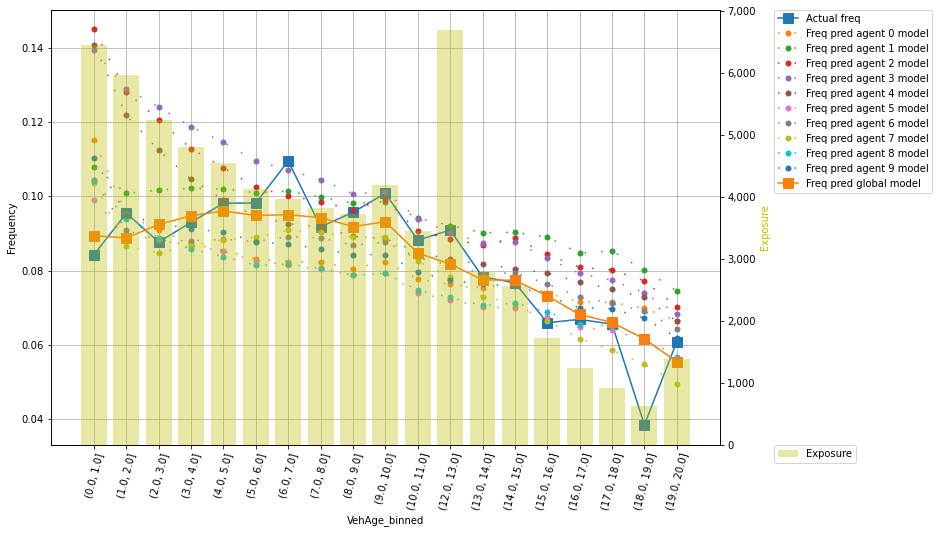

In [23]:
one_way_graph_comparison('VehAge', NUM_AGENTS)

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


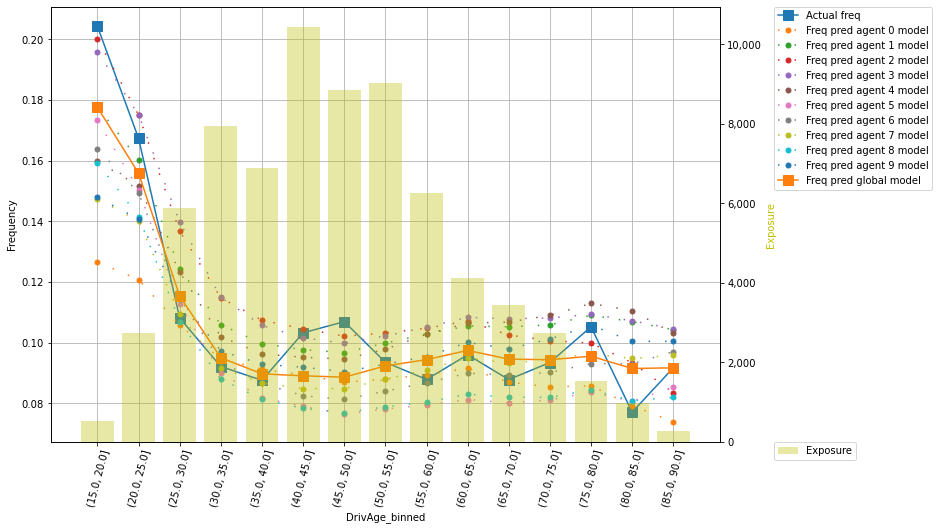

In [24]:
one_way_graph_comparison('DrivAge', NUM_AGENTS)

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


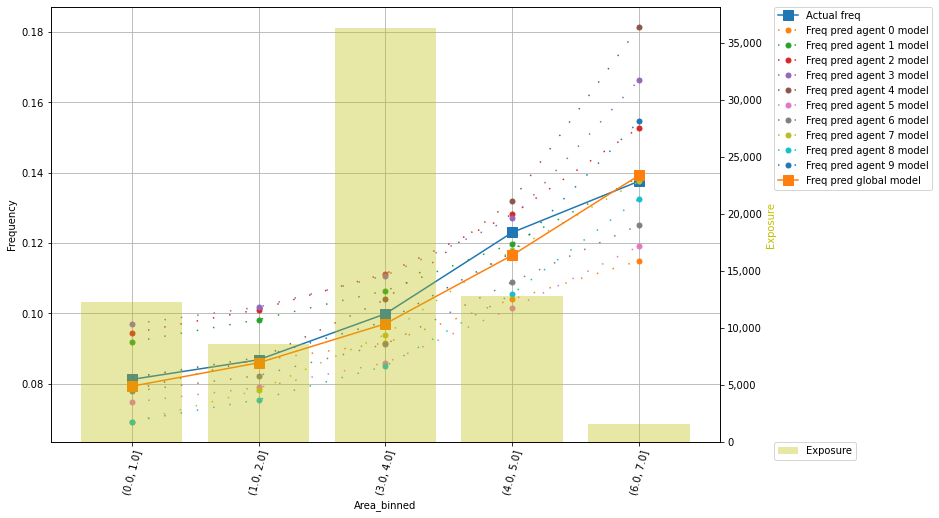

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


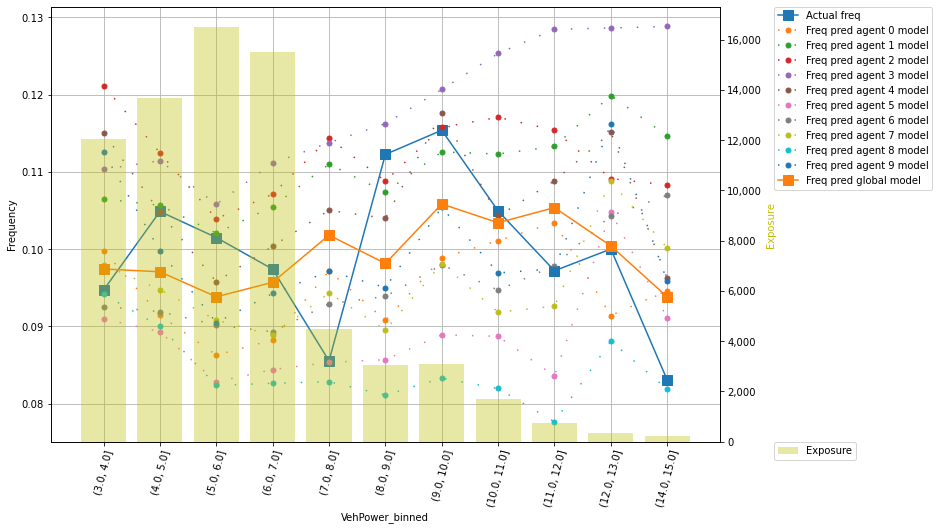

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


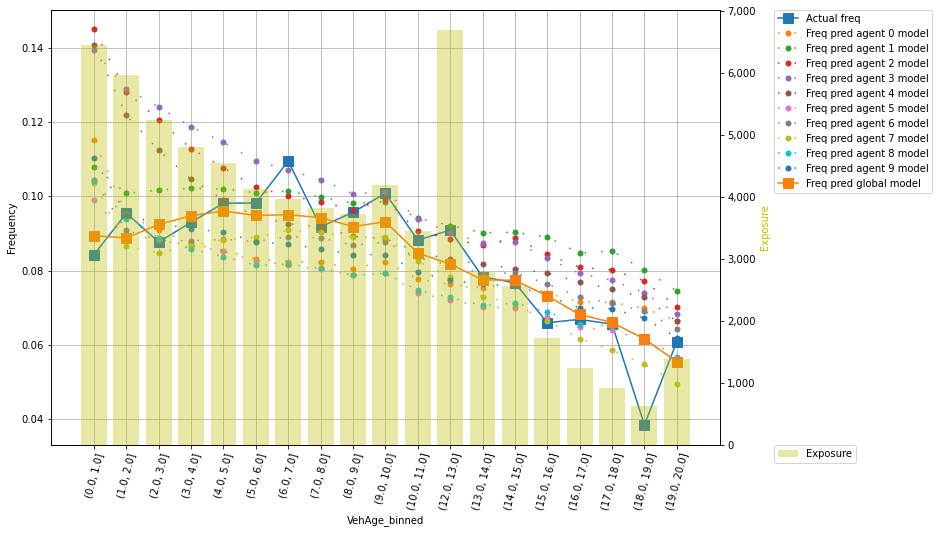

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


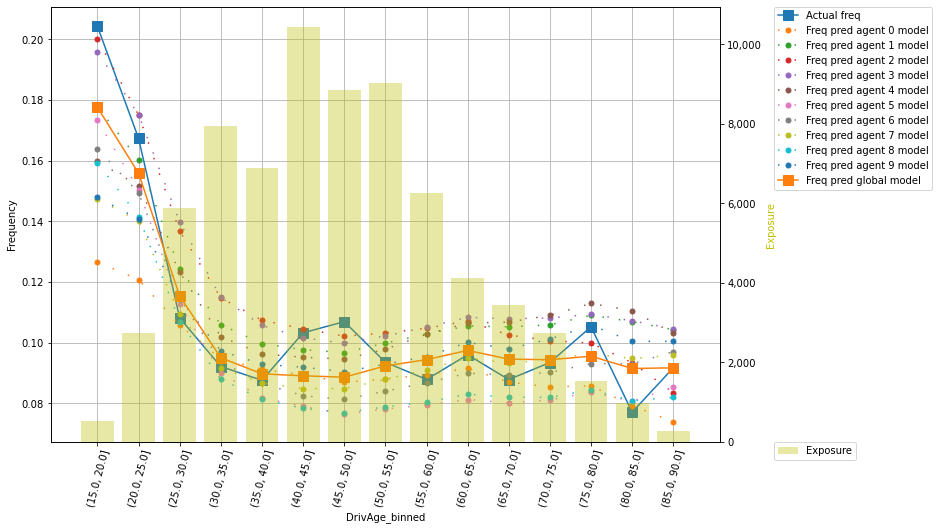

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


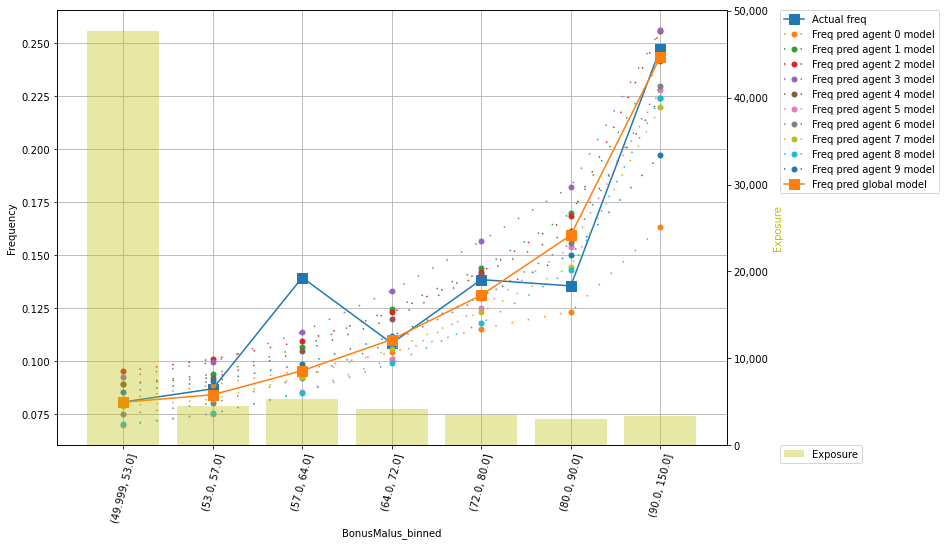

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


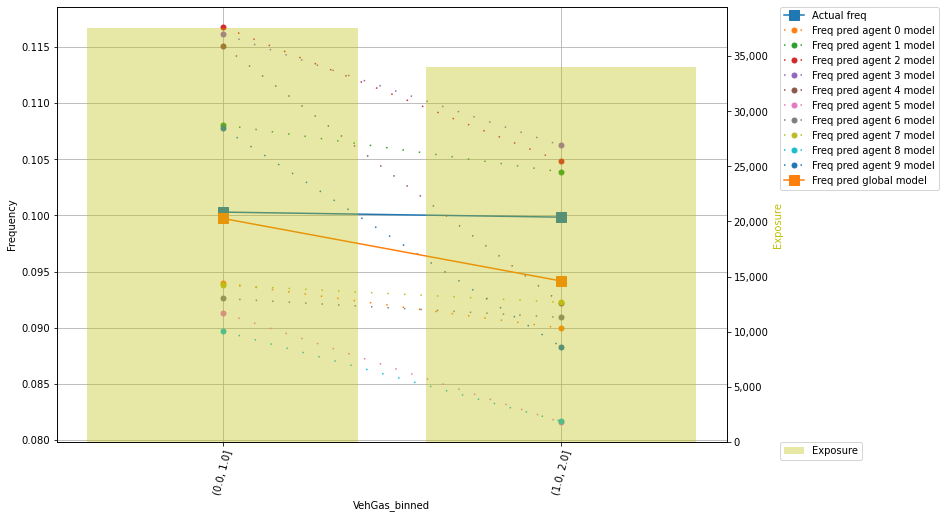

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


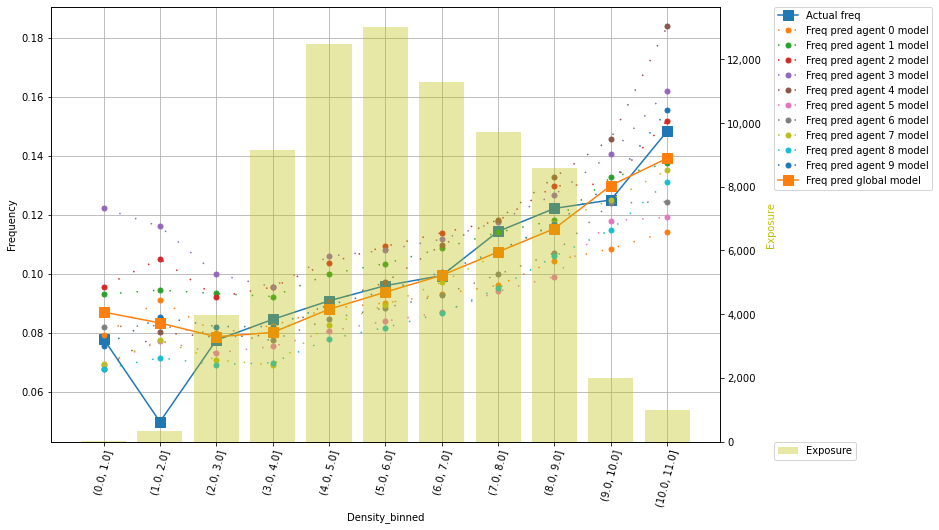

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


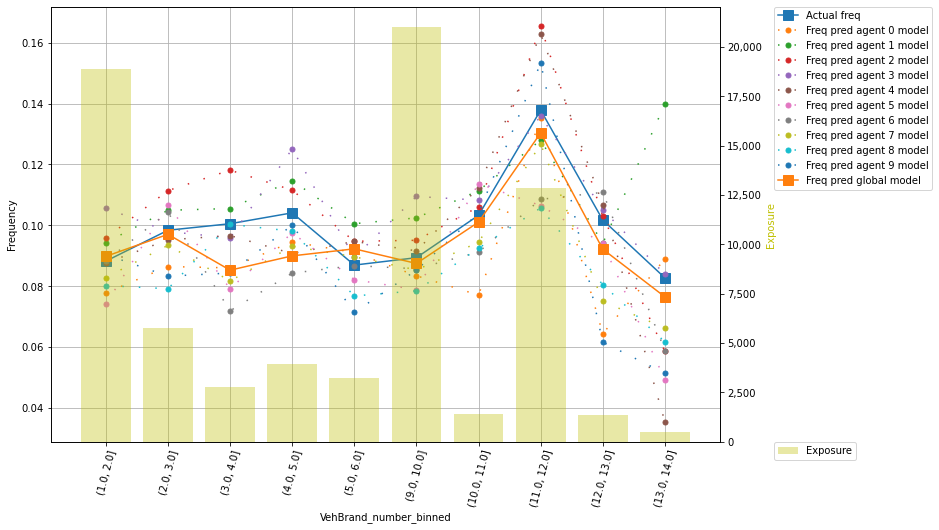

C:\Users\dylan\AppData\Local\Temp\ipykernel_54244\1787733368.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(['{:,.0f}'.format(x) for x in vals])


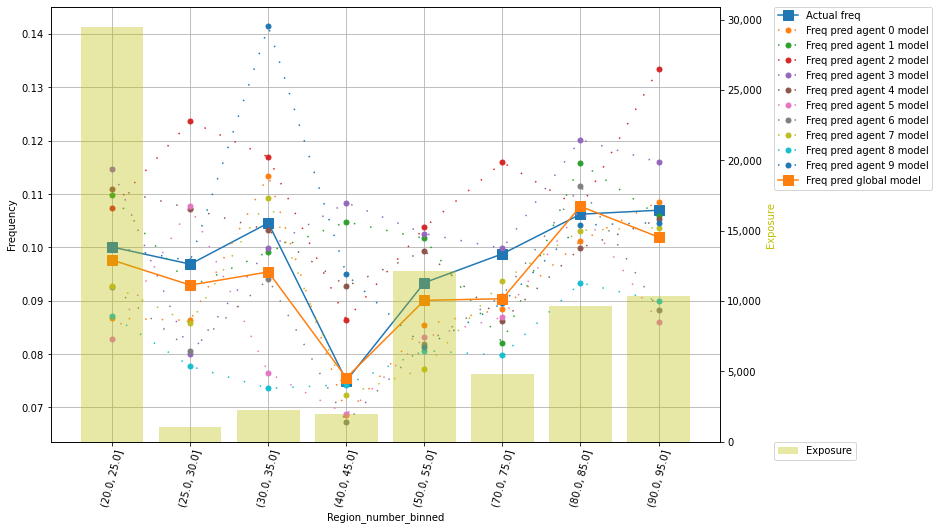

In [25]:
for i in ['Area', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'VehGas', 'Density', 'VehBrand_number', 'Region_number']:
    one_way_graph_comparison(i, NUM_AGENTS)

## Gini

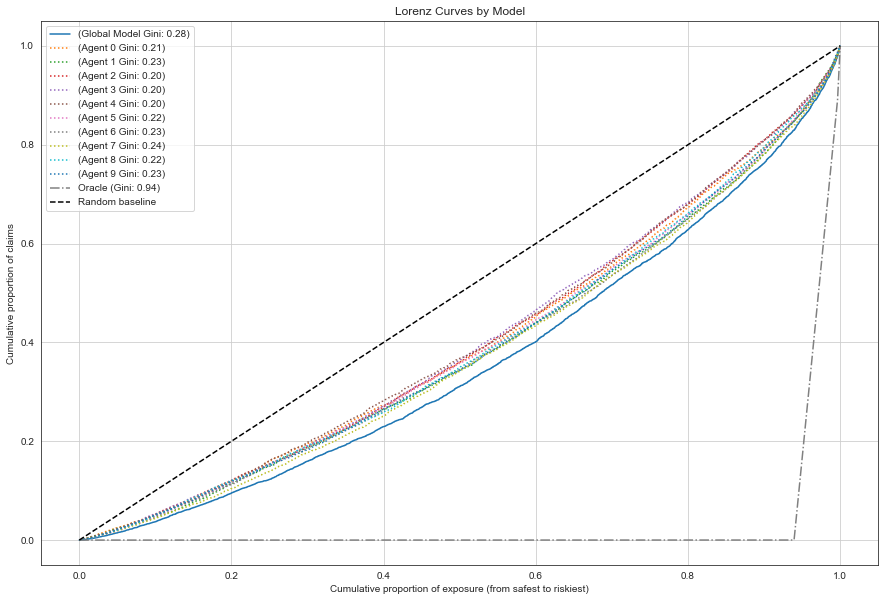

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))

cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb_pred'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "(Global Model Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-", label=label)

for agents in range(NUM_AGENTS):
    cum_exposure, cum_claims = utils.lorenz_curve(
        df_test_pred['ClaimNb'], df_test_pred['ClaimNb_agent_'+str(agents)+'_pred'], df_test_pred["Exposure"]
    )
    gini = 1 - 2 * auc(cum_exposure, cum_claims)
    label = '(Agent {} Gini: {:.2f})'.format(agents, gini)
    plt.plot(cum_exposure, cum_claims, linestyle="dotted", label=label)

# Oracle model: y_pred == y_test
cum_exposure, cum_claims = utils.lorenz_curve(
    df_test_pred['ClaimNb'], df_test_pred['ClaimNb'], df_test_pred["Exposure"]
)
gini = 1 - 2 * auc(cum_exposure, cum_claims)
label = "Oracle (Gini: {:.2f})".format(gini)
ax.plot(cum_exposure, cum_claims, linestyle="-.", color="gray", label=label)

# Random Baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves by Model",
    xlabel="Cumulative proportion of exposure (from safest to riskiest)",
    ylabel="Cumulative proportion of claims",
)

plt.grid()
ax.legend(loc="upper left")

#plt.savefig(f'../ag_{ag}/' + 'lift_chart')

# Metric

In [27]:
top_results_df[['agent', 'test_weighted_pde']]

,agent,test_weighted_pde
0,-1,0.049927
15,0,0.024082
30,1,0.030454
45,2,0.027887
60,3,0.024169
75,4,0.024111
90,5,0.028436
105,6,0.033860
120,7,0.038155
135,8,0.027811


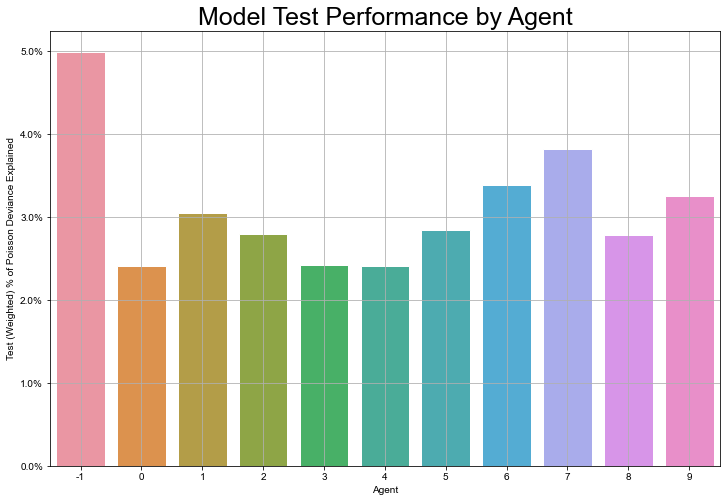

In [28]:
fig, ax = plt.subplots(figsize=(12,8))

sns.set_style('white')

ax=sns.barplot(x='agent', y='test_weighted_pde',
               data=top_results_df[['agent', 'test_weighted_pde']])
plt.title('Model Test Performance by Agent', fontsize=25)

plt.xticks(fontsize=10)
plt.ylabel('Test (Weighted) % of Poisson Deviance Explained', fontsize=10)
plt.xlabel('Agent', fontsize=10)
plt.yticks(fontsize=10)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.grid(True)
plt.show()

# End